In [3]:
import pandas as pd
import scipy.stats as stats

import datetime
from datetime import timedelta

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import plotly.express as px

%matplotlib inline

In [4]:
directory1 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-vedernikova/проект/olist_customers_dataset.csv'
directory2 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-vedernikova/проект/olist_orders_dataset.csv'
directory3 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-vedernikova/проект/olist_order_items_dataset.csv'
olist_customers_dataset = pd.read_csv(directory1) # 99441 rows × 5 columns
olist_orders_dataset = pd.read_csv(directory2) # 99441 rows × 8 columns
olist_order_items_dataset = pd.read_csv(directory3) #112650 rows × 7 columns

### Выводим таблицы на просмотр, чтобы ознакомиться с данными

In [5]:
# таблица с уникальными идентификаторами пользователей
olist_customers_dataset.head(2)
# 99441 rows × 5 columns

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [6]:
# таблица заказов
olist_orders_dataset.head(2)
# 99441 rows × 8 columns

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [7]:
# товарные позиции, входящие в заказы
olist_order_items_dataset.head(2)
#112650 rows × 7 columns

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [8]:
# Проверяем кол-во прпущенных значений в таблице с уникальными идентификаторами пользователей
olist_customers_dataset.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [9]:
# Проверяем кол-во прпущенных значений в таблице заказов
olist_orders_dataset.isna().sum()
# Пропущенные значения в столбцах: 
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [10]:
# Проверяем кол-во прпущенных значений в таблице товарных позиций, входящих в заказы
olist_order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [11]:
df = pd.merge(olist_customers_dataset, olist_orders_dataset, on='customer_id', how='outer')
# Соединили таблицы с уникальными идентификаторами пользователей и таблицу заказов со статусами

In [12]:
df_order_status = df.groupby('order_status').agg({'order_id': 'count'}).reset_index()
df_order_status
# Сколько всего заказов с разными статусами?

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [13]:
df_isna = df.query("order_status in ['created', 'approved', 'invoiced']").isna().sum()
# Проверяю кол-во заказов со статусами указанными выше (321 rows × 12 columns), проверяю кол-во проупщенных значений,
# чтобы убедиться в гипотезе, что этим заказам не назначено время доставки
# order_delivered_carrier_date     321
# order_delivered_customer_date    321

Заказы со статусами 'created', 'approved', 'invoiced' не стоит учитывать, т.к. эти заказы не оплачены, они идут до статуса 'processing - в процессе сборки заказа'.
Заказы со статусами 'unavailable —  недоступен' и 'canceled —  отменён'.
Соответственно успешными на момент анализа заказы считаются со статусами: 'processing —  в процессе сборки заказа', 'shipped —  отгружен со склада', 'delivered —  доставлен пользователю'

In [14]:
customer_unique = df.query("order_status in ['processing', 'shipped', 'delivered']") \
                    .groupby('customer_unique_id') \
                    .agg(count_order_id =('order_id', 'count')) \
                    .reset_index()

customer_unique
# 94686 rows × 2 columns

,customer_unique_id,count_order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94681,fffcf5a5ff07b0908bd4e2dbc735a684,1
94682,fffea47cd6d3cc0a88bd621562a9d061,1
94683,ffff371b4d645b6ecea244b27531430a,1
94684,ffff5962728ec6157033ef9805bacc48,1


In [15]:
customer_one_purchase = customer_unique.query('count_order_id == 1').count()
customer_one_purchase

customer_unique_id    91814
count_order_id        91814
dtype: int64

91814 покупателей совершили покупку только один раз.

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [16]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'], errors='coerce')
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'], errors='coerce')
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'], errors='coerce')

In [17]:
df['purchase_month'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce').dt.strftime('%B %Y')

In [18]:
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
purchase_month                           object
dtype: object

Учитывая решение первой задачи и анализируя статусы, мы при анализе не доставленных заказов однозначно не считаем успешные (delivered — доставлен пользователю), а также нет смысла считать заказы, которые не оплачены, а также, которые стали только собраны после оплаты и отправлены, но не дошли, так как высокая вероятность завершения сделки успешно. Поэтому в расчет будут браться только заказы в завершенным "неуспешным" статусом: unavailable — недоступен и canceled — отменён.

Фильтровать месяцы заказов будем по столбцу order_estimated_delivery_date - обещанная дата доставки, т.к. этот столбец не имеет пропущенных значений и в нем заложено время, необходимое для доставки заказа во время. Т.е. на выполнение условия доставки с нашей стороны мы ориентировались бы на этот столбец. Созданный стлбец 'order_purchase_M/Y' на основе order_estimated_delivery_date отображает месяц и год покупки

In [19]:
not_delivered = df.query("order_status in ['unavailable', 'canceled']") \
                .groupby(['purchase_month', 'order_status']) \
                .agg(count=('order_id', 'count'))
# таблица с подсчитанными значениями за каждый месяц

In [22]:
not_delivered.mean().round()

count    27.0
dtype: float64

В среднем с апреля 2017 по сентябрь 2018 не доставлено 27 заказов.
И посмотрим среднее значение недоставленных заказов за этот период с группировкой по статусу:

In [23]:
not_delivered.groupby(['order_status']).agg(mean=('count','mean')).round().reset_index()

,order_status,mean
0,canceled,26.0
1,unavailable,29.0


С разбивкой по статусу среднее значение отменных заказов в месяц: 26, недоступных: 29.

Дополнительный анализ отмененных заказов: Можно ознакомиться с динамикой отменных заказов по периодам:

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 <a list of 24 Text major ticklabel objects>)

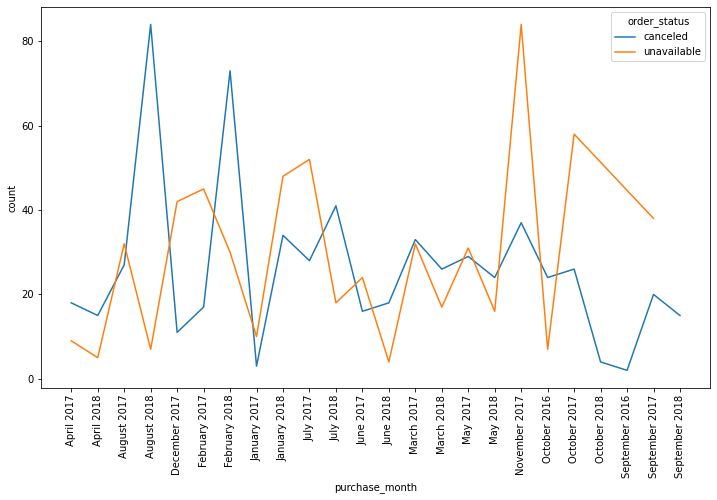

In [24]:
plt.figure(figsize=(12, 7))
sns.lineplot(x='purchase_month', y='count', hue='order_status', data=not_delivered)
plt.xticks(rotation=90)

Данный график визуаилизурет динамику увеличения отмененных и недоступных заказов по месяцам.
Мы видим, что первый пик недоступных заказов приходится на ноябрь 2017, второй пик на декабрь 2017.
Два самых высоких значения отмененных заказов приходятся на март и август в 2018 году.
Также можно обратить внимание на 2 месяца, где сравнительно низкий показатель отмененных заказов - Февраль 2017 и Январь 2018.

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [25]:
df2 = pd.merge(olist_orders_dataset, olist_order_items_dataset, on='order_id')

In [26]:
df2.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76


In [27]:
df2.isna().sum()
# 15 пропущенных строк в стоблце 'order_approved_at'

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

In [28]:
df2['order_purchase_timestamp'] = pd.to_datetime(df2['order_purchase_timestamp'])

In [29]:
df2['day_of_week'] = df2['order_purchase_timestamp'].dt.day_name()
# Используем день создания заказа

In [30]:
df2.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday


In [31]:
df2['order_status'].value_counts()
#Будем исключать из подсчета отменные и недоступные заказы

delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64

In [32]:
df2['product_id'].nunique()
# Количество товаров

32951

In [33]:
product_id_sales = df2.query("order_status in ['processing', 'shipped', 'delivered']") \
                    .groupby(['product_id', 'day_of_week']) \
                    .agg(count=('product_id', 'count')) \
                    .sort_values('count', ascending = False) \
                    .reset_index()
product_id_sales.head(3)

,product_id,day_of_week,count
0,422879e10f46682990de24d770e7f83d,Wednesday,93
1,99a4788cb24856965c36a24e339b6058,Monday,92
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89


In [34]:
max_sales_per_day = product_id_sales.groupby('product_id')['count'].idxmax()
most_sold_days = (product_id_sales.loc[max_sales_per_day, ['product_id', 'day_of_week', 'count']]).sort_values('count')
# применяем метод .idxmax() к столбцу 'count', чтобы найти индекс строки с максимальным значением 'count' для каждой группы.
# Метод .loc[] для выбора соответствующих строк из DataFrame product_id_sales на основе индексов
# максимальных значений. Мы выбираем столбцы 'product_id', 'day_of_week' и 'count', чтобы получить информацию о товаре,
# дне недели и количестве продаж.

### Таблица отображающая в какой день недели каждый товар больше всего покупается:

In [35]:
most_sold_days

,product_id,day_of_week,count
35648,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
21459,9d6332c3e975253362b8cfbbd71f5a25,Friday,1
21457,9d60109d64bee97e7112ea96e57992dc,Sunday,1
21456,9d5cb049d3a927647b8c105a67bce2ef,Tuesday,1
21454,9d5aabe3e3265ed911b2a85d14474635,Monday,1
...,...,...,...
13,368c6c730842d78016ad823897a372db,Friday,67
8,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
1,99a4788cb24856965c36a24e339b6058,Monday,92


В связи с тем, что таблица имеет достаточно большое количество артикулов, для детализации дополнительно можно рассмотреть ТОП-10 часто покупаемых товаров по дням недели.

Выведем ТОП-10 продаж в штуках по дням недели и для наглядности отобразим в графиках

In [36]:
most_sold_mon = (most_sold_days.query('day_of_week == "Monday"').sort_values('count', ascending = False)).head(10)
most_sold_tue = (most_sold_days.query('day_of_week == "Tuesday"').sort_values('count', ascending = False)).head(10)
most_sold_wed = (most_sold_days.query('day_of_week == "Wednesday"').sort_values('count', ascending = False)).head(10)
most_sold_thu = (most_sold_days.query('day_of_week == "Thursday"').sort_values('count', ascending = False)).head(10)
most_sold_fri = (most_sold_days.query('day_of_week == "Friday"').sort_values('count', ascending = False)).head(10)
most_sold_sat = (most_sold_days.query('day_of_week == "Saturday"').sort_values('count', ascending = False)).head(10)
most_sold_sun = (most_sold_days.query('day_of_week == "Sunday"').sort_values('count', ascending = False)).head(10)
# Вычислили ТОП-10 продаж в штуках для каждого дня недели отдельно

In [37]:
# Объединяем в одну таблицу для наглядного единого графика
dfs = [most_sold_mon, most_sold_tue, most_sold_wed, most_sold_thu, most_sold_fri, most_sold_sat, most_sold_sun]
top_10_week = pd.concat(dfs, axis=0)

Text(0.5, 1.0, 'ТОП-10 продаж в штуках по дням недели')

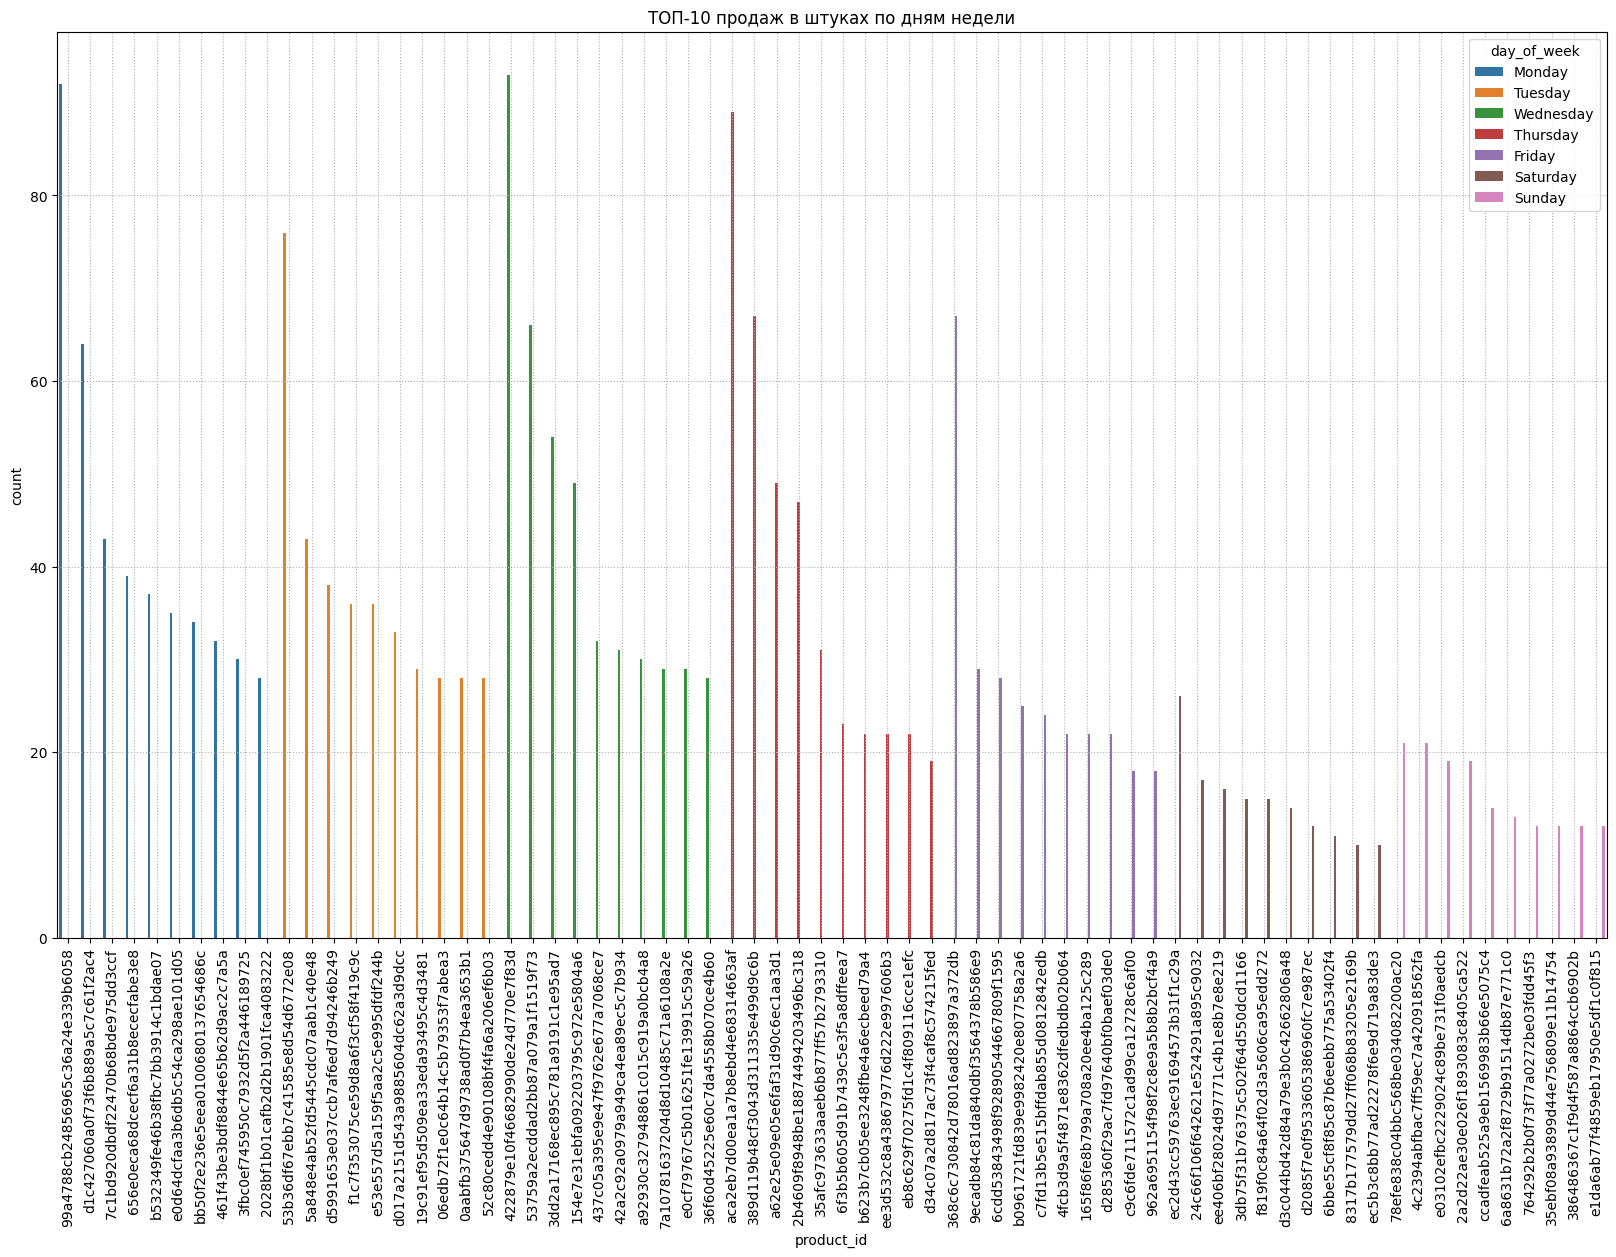

In [38]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=100)
ax = sns.barplot(x='product_id', y='count', hue='day_of_week', alpha=1, data=top_10_week)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(linestyle='dotted')
plt.title('ТОП-10 продаж в штуках по дням недели')

На графике выше отображено распредление продаж товаров в штуках согласно таблице ТОП-10. Распределение ТОП-10 по дням недели также подтверждает, что продажи к выходным начинают спадать.

In [39]:
top_10_week['product_id'].nunique()
# В список ТОП-10 продаж по дням недели в ежедневный ТОП-10 не попадают повторяющиеся артикулы.

70

In [40]:
# Посмотрим распределение общего количества товаров по дням недели:
sales_day_of_week = product_id_sales.groupby(['day_of_week']).agg(sum_products=('count', 'sum')).sort_values('sum_products').reset_index()

Text(0.5, 1.0, 'Продажи в штуках по дням недели')

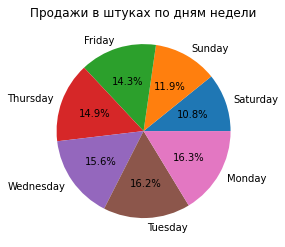

In [41]:
plt.pie(sales_day_of_week['sum_products'], labels=sales_day_of_week['day_of_week'], autopct='%1.1f%%')
plt.title('Продажи в штуках по дням недели')

Лидирующие дни недели по покупкам - Понедельник и вторник, третье место у среды с небольшим отрывом.

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Будем использовать время оформления заказа пользователем - Оrder_purchase_timestamp.
На его основе ранее создан стобец 'purchase_month' с отображением месяца и года.

In [42]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['weeks'] = (df['order_purchase_timestamp'].dt.daysinmonth) / 7

In [43]:
customer_purchase_mean = df.query("order_status in ['processing', 'shipped', 'delivered']") \
                    .groupby(['customer_unique_id', 'purchase_month', 'weeks']) \
                    .agg({'order_id': 'count'}) \
                    .reset_index() \
                    .groupby(['weeks', 'customer_unique_id']) \
                    .agg(mean_for_a_month=('order_id', 'mean')) \
                    .sort_values('mean_for_a_month', ascending=False) \
                    .reset_index()
# получено среднее значение покупок в месяц для каждого пользователя

In [44]:
customer_purchase_mean['mean_for_a_week'] = customer_purchase_mean['mean_for_a_month'] / customer_purchase_mean['weeks']

In [45]:
df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,weeks
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,May 2017,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,January 2018,4.428571


In [46]:
customer_purchase_mean.drop('weeks', axis=1, inplace=True)
#удалить лишний столбец

In [47]:
customer_purchase_mean

,customer_unique_id,mean_for_a_month,mean_for_a_week
0,12f5d6e1cbf93dafd9dcc19095df0b3d,6.0,1.354839
1,a239b8e2fbce33780f1f1912e2ee5275,4.0,1.000000
2,b08fab27d47a1eb6deda07bfd965ad43,4.0,0.933333
3,25a560b9a6006157838aab1bdbd68624,4.0,0.933333
4,83e7958a94bd7f74a9414d8782f87628,4.0,0.903226
...,...,...,...
95753,ced5b7e4e431e11775c4bcf19443e008,1.0,0.233333
95754,ced43e4c9c807745b25ad6c5d519859e,1.0,0.233333
95755,cecc19ff12c206e6368dd1e9c22a848d,1.0,0.233333
95756,cec9f54c6af7bd9e26e187e22a2b6230,1.0,0.233333


# 5. Выполните когортный анализ пользователей.

In [48]:
# Столбец purchase_month - это месяц, когда создан заказ
df['purchase_month'] = pd.to_datetime(df['purchase_month'])
df['min_purchase_date'] = df.groupby('customer_unique_id')['purchase_month'].transform('min')

In [49]:
df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month,weeks,min_purchase_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-01,4.428571,2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-01,4.428571,2018-01-01


Необходимо посчитать Retention Rate — это коэффициент удержания клиентов.

In [50]:
# Группировка данных по когортам и месяцам для определения уникальных клиентов в каждой когорте
cohort_counts = df.groupby(['min_purchase_date', 'purchase_month'])['customer_unique_id'].nunique().reset_index()

In [51]:
# Группировка данных по когортам и месяцам для определения клиентов с повторными покупками
repeat_customers = df.groupby(['min_purchase_date', 'purchase_month'])['customer_unique_id'].count().reset_index()

In [52]:
cohort_analysis = pd.merge(cohort_counts, repeat_customers, on=['min_purchase_date', 'purchase_month'], suffixes=('_unique', '_repeat'))

In [53]:
# Расчет коэффициента оборота (rotation rate)
cohort_analysis['rotation_rate'] = (cohort_analysis['customer_unique_id_repeat'] / cohort_analysis['customer_unique_id_unique']) * 100

In [54]:
cohort = cohort_analysis.pivot_table(index='min_purchase_date', columns='purchase_month', values='rotation_rate')

In [55]:
cohort.head(2)

purchase_month,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01
min_purchase_date,,,,,,,,,,,,,,,,,,,,,
2016-09-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,NaN,100.934579,NaN,NaN,NaN,NaN,100.0,NaN,NaN,100.0,...,100.0,NaN,100.0,NaN,100.0,100.0,NaN,NaN,NaN,NaN


In [56]:
cohort_counts = df.query('order_status in ["processing", "shipped", "delivered"]') \
                .groupby(['min_purchase_date', 'purchase_month'], as_index=False) \
                .agg(unique_customers=('customer_unique_id', 'nunique'))

In [57]:
cohort_counts['month_num'] = ((cohort_counts['purchase_month'] - cohort_counts['min_purchase_date']) / np.timedelta64(1, 'M')).astype(int)

In [58]:
cohort_counts.dtypes

min_purchase_date    datetime64[ns]
purchase_month       datetime64[ns]
unique_customers              int64
month_num                     int64
dtype: object

In [59]:
cohort_counts.head(2)

,min_purchase_date,purchase_month,unique_customers,month_num
0,2016-09-01,2016-09-01,2,0
1,2016-10-01,2016-10-01,272,0


In [60]:
cohort_counts_pivot = cohort_counts.pivot_table(index = 'min_purchase_date', columns = 'month_num', values = 'unique_customers')

In [61]:
cohort_counts_pivot.head(2)

month_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
min_purchase_date,,,,,,,,,,,,,,,,,,,,
2016-09-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,272.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,2.0,2.0


In [62]:
# Приводим данные первого столбца к 1.0
first = cohort_counts_pivot[0]
# И рассчитаем возвращаемость
retention = cohort_counts_pivot.divide(first, axis = 0)

In [63]:
# визуализация
retention_perc = (retention
            .style
            .set_caption('User retention by cohort')
            .background_gradient(cmap='Blues')
            .highlight_null('white')
            .format("{:.2%}", na_rep="")
            .set_table_styles([{'selector': 'caption',
                               'props': [('font-size', '16pt')]}]))

In [64]:
retention_perc

month_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
min_purchase_date,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:00:00,100.00%,,,,,,,,,,,,,,,,,,,
2016-10-01 00:00:00,100.00%,,,,,0.37%,,,0.37%,,,0.37%,,0.37%,,0.37%,0.37%,,0.74%,0.74%
2016-12-01 00:00:00,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,100.00%,0.34%,0.14%,0.41%,0.14%,0.41%,0.14%,0.14%,,0.41%,0.14%,0.68%,,0.27%,0.14%,0.27%,0.41%,,0.14%,
2017-02-01 00:00:00,100.00%,0.59%,0.24%,0.83%,0.24%,0.48%,0.36%,0.36%,0.48%,0.24%,0.59%,0.36%,0.36%,0.24%,0.12%,0.12%,0.48%,,,
2017-03-01 00:00:00,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.35%,0.18%,,0.14%,,0.23%,0.08%,0.16%,,
2017-04-01 00:00:00,100.00%,,0.39%,,0.69%,0.52%,0.69%,0.60%,0.60%,0.34%,0.34%,0.17%,0.09%,0.17%,0.17%,,0.43%,,,
2017-05-01 00:00:00,100.00%,0.51%,0.51%,0.40%,0.31%,0.34%,0.43%,0.17%,0.26%,0.26%,,0.30%,,0.11%,,0.26%,,,,
2017-06-01 00:00:00,100.00%,,0.71%,0.77%,0.51%,0.71%,0.77%,0.45%,0.35%,0.64%,0.64%,0.32%,0.26%,0.39%,,,,,,


Ответ: Когорта от сентября 2017 имеет самое высокое значение возвращаемости на третий месяц - 0,83%.

Общий анализ:
    Большинство пользователей делают только один заказ. Процент возвращаемости пользователей в лучшем случае достигает 0,83-0,88% в разные временные периоды разными когортами. Минимальное значение возвращаемости, кроме нулевого, 0,09% у когорты апреля 2017 г (и 0,02% у когорты 2018 августа).
Наиболее высокие значения встречаются у когорт 2017 года: январь, февраль, апрель, июнь, сентябрь.
    Когорты от апреля и июня 2017 имеют довольно длительный период времени одинаково высокий показатель возвращаемости от месяца к месяцу близкий к стабильному. 
    В данном отчетном периоде видно, что большиснтво пользователей, которые пришли в 2016 году - сделали всего 1 заказ. Но при этом стоить отметить, что период конца 2016 года, а это 3 когорты за сентябрь, октябрь, декабрь успешным месяцем по первому привлечению был лишь октябрь, пришло 272 уникальных пользователя. В Сентябре и декабре уникальных пользователей ничтожно мало - общее количество 3 чел.

# 6. Построй RFM-сегментацию пользователей

Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

В кластеризации можешь выбрать следующие метрики:

-  R - время от последней покупки пользователя до текущей даты,
-  F - суммарное количество покупок у пользователя за всё время,
-  M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.

Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [65]:
rfm = pd.merge(df, olist_order_items_dataset, on='order_id')
# Все 3 таблицы объединены в одну
# 112650 rows × 21 columns количество строк совпадает с третьей таблицей

In [66]:
print('Orders from {} to {}'.format(rfm['order_purchase_timestamp'].min(),
                                    rfm['order_purchase_timestamp'].max()))
# Каковы временные рамки данных?

Orders from 2016-09-04 21:15:19 to 2018-09-03 09:06:57


Данные за полный год есть только в периоде с января 2017 по декабрь 2017, поэтому период исследования будет использоваться лишь за этот период. 

In [67]:
rfm = rfm.query('order_status == ["processing", "shipped", "delivered"] and "2017-01" <= order_purchase_timestamp < "2018-01"')

In [68]:
print('Orders from {} to {}'.format(rfm['order_purchase_timestamp'].min(),
                                   rfm['order_purchase_timestamp'].max()))
# Проверяю временной период после фильтрации

Orders from 2017-01-05 11:56:06 to 2017-12-31 23:29:31


In [69]:
# rfm.isna().sum()
# пропущенных значений по нужным строкам нет

In [70]:
rfm.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
purchase_month                   datetime64[ns]
weeks                                   float64
min_purchase_date                datetime64[ns]
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           

In [71]:
# За обозначение текущей даты возьмем максимальную дату создания заказа + 1 день
today = rfm.order_purchase_timestamp.max() + timedelta(days=1)

In [72]:
rfm_1 = rfm.groupby('customer_unique_id', as_index = False) \
    .agg({'order_purchase_timestamp': lambda x:(today - x.max()).days, 'order_id': 'count', 'price': 'sum'}) \
    .rename(columns = {'order_purchase_timestamp': 'Recency', 'order_id': 'Frequency', 'price': 'Monetary'})

In [73]:
rfm_1.head(4)

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,297,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00


-  Recency (Давность) — Как давно клиент совершил покупку?
-  Frequency (Частота) — Как часто они совершают покупки?
-  Monetary Value (Денежная ценность) — Сколько они тратят?

Получаем квантили для каждого параметра. Каждый квинтиль содержит 20% покупателей.

In [74]:
quantile = rfm_1.quantile(q=[.2, .4, .6, .8]).to_dict()
quantile

{'Recency': {0.2: 38.0, 0.4: 92.0, 0.6: 156.0, 0.8: 232.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 68.9, 0.6: 108.0, 0.8: 179.9}}

Для столбца 'F' - Frequency использовать квантили некорректно, т.к. везде получается одно значение в связи с тем, что большинства покупателей делают всего 1 покупку.

Для Recency и Monetary можно использовать метод квантилей.

In [75]:
rfm_1.describe()

,Recency,Frequency,Monetary
count,42864.000000,42864.000000,42864.000000
mean,137.899543,1.175975,141.854822
std,95.512189,0.599668,223.675392
min,1.000000,1.000000,2.290000
25%,48.000000,1.000000,47.990000
50%,124.000000,1.000000,89.000000
75%,214.000000,1.000000,155.000000
max,361.000000,21.000000,13440.000000


In [76]:
rfm_1['R'] = pd.cut(rfm_1.Recency, bins = [0, 47, 123, 213, 361], 
                                     labels = ['4', '3', '2', '1'])
rfm_1['F'] = pd.cut(rfm_1.Frequency, bins = [0, 3, 6, 9, 21], 
                                     labels = ['1', '2', '3', '4'])
rfm_1['M'] = pd.cut(rfm_1.Monetary, bins = [0, 46, 88, 154, 13440], 
                                     labels = ['1', '2', '3', '4'])

rfm_1['R'] = rfm_1['R'].astype(str)
rfm_1['F'] = rfm_1['F'].astype(str)
rfm_1['M'] = rfm_1['M'].astype(str)

In [77]:
# Объединяем
rfm_1['RFM_score'] = rfm_1['R'] + rfm_1['F'] + rfm_1['M']
rfm_1

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_score
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,2,112
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,3,1,1,311
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,3,1,4,314
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,1,1,3,113
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211
...,...,...,...,...,...,...,...,...
42859,fffbf87b7a1a6fa8b03f081c5f51a201,5,1,149.00,4,1,3,413
42860,fffcf5a5ff07b0908bd4e2dbc735a684,207,2,1570.00,2,1,4,214
42861,fffea47cd6d3cc0a88bd621562a9d061,22,1,64.89,4,1,2,412
42862,ffff371b4d645b6ecea244b27531430a,328,1,89.90,1,1,3,113


Каждый клиент получит примечание от 1 до 4 баллов для каждого параметра.
Я использовала такую шкалу:

   Recency - время от последней покупки пользователя до текущей даты:
   
-  1 - От 214 дней до 361 (Использовано максимальное значение, при этом, напоминаю, что в анализ вошел 1 год)
-  2 - От 124 до 213 дней
-  3 - От 48 до 123 дней
-  4 - От 0 до 47 дней


   Frequency - суммарное количество покупок у пользователя за всё время:
-  1 - До 3х  покупок 
-  2 - От 4х до 6 покупок
-  3 - От 7 до 9 покупок
-  4 -  От 10 до 21 покупки

Деление Frequency выбрано интуинтивно на основе количества заказов

   Monetary - сумма покупок за всё время:
-  1 - От 0 до 46
-  2 - От 47 до 88
-  3 - От 89 до 154
-  4 - Свыше 155
Recency и Monetary выбрано исходя из распределения rfm_1.describe()

Чем больше сумма в 'RFM_score' - тем выше оценка

In [78]:
rfm_1['RFM_score'].nunique()

42

In [ ]:
По нашей таблице получилось 42 уникальных оценки. Для упрощения анализа необходимо объединить эти оценки в группы лояльности.

In [80]:
RFM_score = rfm_1.groupby(['RFM_score']).agg(count=('RFM_score', 'count')).reset_index()

In [89]:
RFM_score.head(2)
# таблица для знакомства с тем, какие оценки есть и в каком количестве

,RFM_score,count
0,111,2852
1,112,2467


In [96]:
# Присвоение Сегментации
segt_map = {
    r'11[1-4]': 'hibernating',
    r'12[1-4]': 'lost',
    r'13[4-9]': 'lost',
    r'14[1-4]': 'lost',
    r'21[1-4]': 'sleepers',
    r'22[1-4]': 'cold loyalty',
    r'23[1-4]': 'cold loyalty',
    r'24[1-3]': 'cold loyalty',
    r'31[1-4]': 'new clients',
    r'41[1-4]': 'new clients',
    r'32[1-4]': 'loyalty',
    r'42[1-4]': 'loyalty',
    r'33[1-4]': 'loyalty',
    r'43[1-4]': 'loyalty',
    r'(2|3|4)44': 'VIP'}

rfm_1['Segment'] = rfm_1['RFM_score'].astype(str).replace(segt_map, regex=True)

### Таблица с разделением клиентов на сегменты

In [97]:
rfm_1.head(3)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_score,Segment
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,2,112,hibernating
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,3,1,1,311,new clients
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,3,1,4,314,new clients


Сегменты присвоены следующим образом:
1. <b>hibernating</b> - бездействие - купили давно, от 1й до 3х покупок, неважно на какую сумму
2. <b>lost</b> - потерянные - купили давно, от 4х до максимального количества покупок, неважно на какую сумму
3. <b>sleepers</b> - спящие - от 1й до 3х покупок в районе полугода, не важно на какую сумму
4. <b>cold loyality</b> - холодные лояльные - последняя покупка от 124 до 213 дней, покупок от 4х до 9, не важно на какую сумму.
5. <b>new clients</b> - новые клиенты - от 1 до 3х покупок с давностью не более 123 дней
6. <b>loyality</b> - лояльные - от 4х покупок с давностью не более 123 дней.
7. <b>VIP</b> - вип - клиенты с давностью покупки не более 213 дней, от 10 покупок на большие суммы.

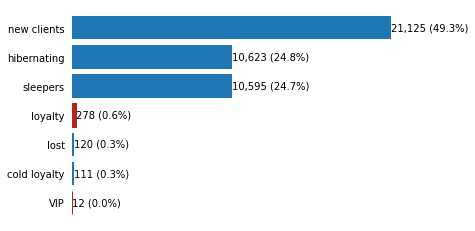

In [102]:
# count the number of customers in each segment
segments_counts = rfm_1['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts)
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
    value = bar.get_width()
    if segments_counts.index[i] in ['VIP', 'loyalty']:
        bar.set_color('firebrick')
    ax.text(value,
            bar.get_y() + bar.get_height()/2,
            '{:,} ({:.1f}%)'.format(int(value), value*100/segments_counts.sum()),
            va='center',
            ha='left'
           )

plt.show()

   Основная часть клиентов у нас совершила 1 покупку, эта информация подтверждается анализом когорт из задачи 5, а также это очевидно из графика выше, что 'hibernating', бездействующих клиентов у нас 24,8%. 24,7% клиентов относится к спящим 'sleepers' и этот сегмент клиентов сделал не более 3х покупок более полугода назад.
   
   Почти 50% клиентов мы можем отнести к НОВЫМ, у них не более трех покупок с давностью не более 123 дней. На этот сегмент рекомендуется применить маркетинговые приемы по их возвращению, т.к., во-первых, это очень большой сегмент покупателей приносящих прибыль, во-вторых, давность их покупки предполагает, что у них еще не забылись положительные впечатления после покупки.
   
   Лояльных и холодных лояльных по 0,6% и 0,3% соотвественно. VIP клиентов почти 0%, 12 человек, это покупатели с более чем 10 покупками на большие суммы. Не смотря на малое количество, захотелось выделить их отдельно для возможности рассмотрения премиального пакета услуг.

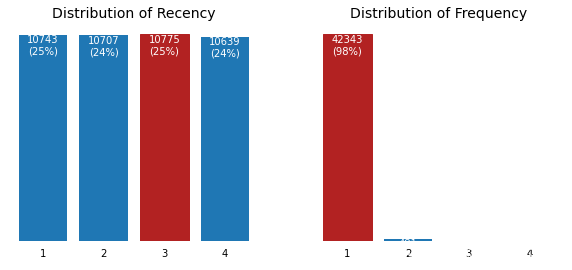

In [106]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm_1[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y)
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Распределение недавности покупки выглядит равномерно распределенной.
Распределение количества покупок подтверждает, что основная часть клиентов (98%) на момент анализа делает не более 3х покупок. 